# Predicting number of Covid19 deaths using Time Series Analysis (ARIMA MODEL)

In [1]:
# We use supressMessages so we won't display the warning message. 
suppressMessages(library(tidyverse))
suppressMessages(library(ggplot2))
suppressMessages(library(zoo))
suppressMessages(library(aTSA))
suppressMessages(library(tseries))
suppressMessages(library(forecast))
suppressMessages(library(lubridate))


In [ ]:
df <- data.frame()
ggplot(df) + geom_point() + ylim(0, 100) + scale_x_continuous(breaks=seq(1, 12, 1), 
                       limits = c(1, 12)) + xlab("Months") + ylab("Outcome Variable") +geom_hline(yintercept=50, 
                color = "red", size=1)+ggtitle("Constant Y Values")



In [ ]:
t=seq(-10,10,0.1)
y=sin(t)
qplot(t,y,geom="path", xlab="time", ylab="Sine wave", col = "red")+  coord_cartesian(ylim=c(-5,5))+geom_hline(yintercept=0, 
                color = "black", size=1)+geom_vline(xintercept=0, 
                color = "black", size=1)+ggtitle("sin(x) Function")+theme(legend.position = "none")


[1] "factor"

[1] "Date"

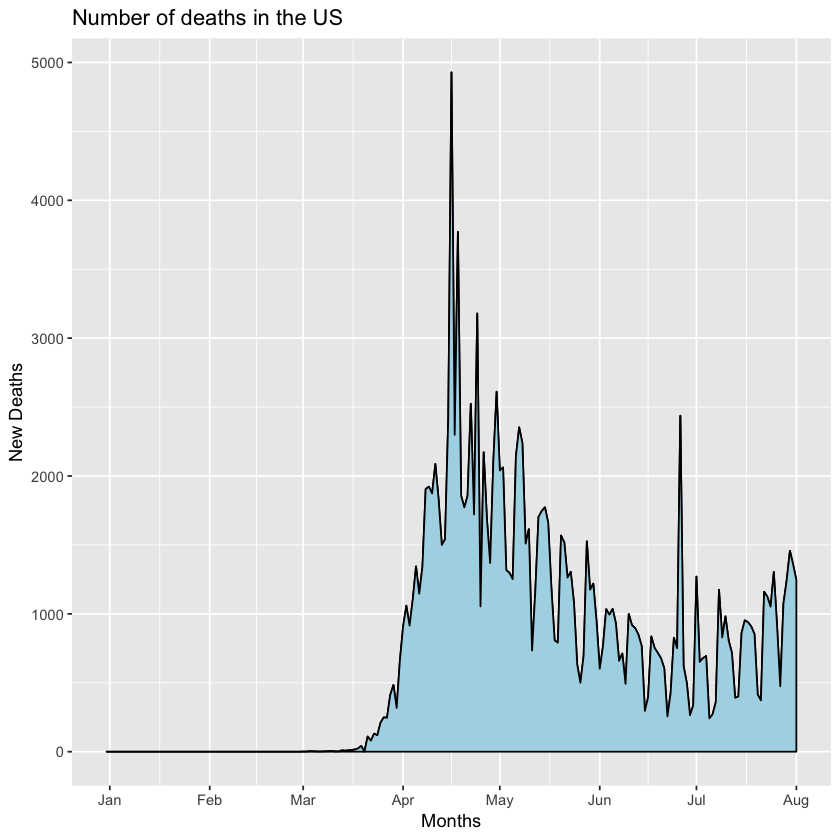

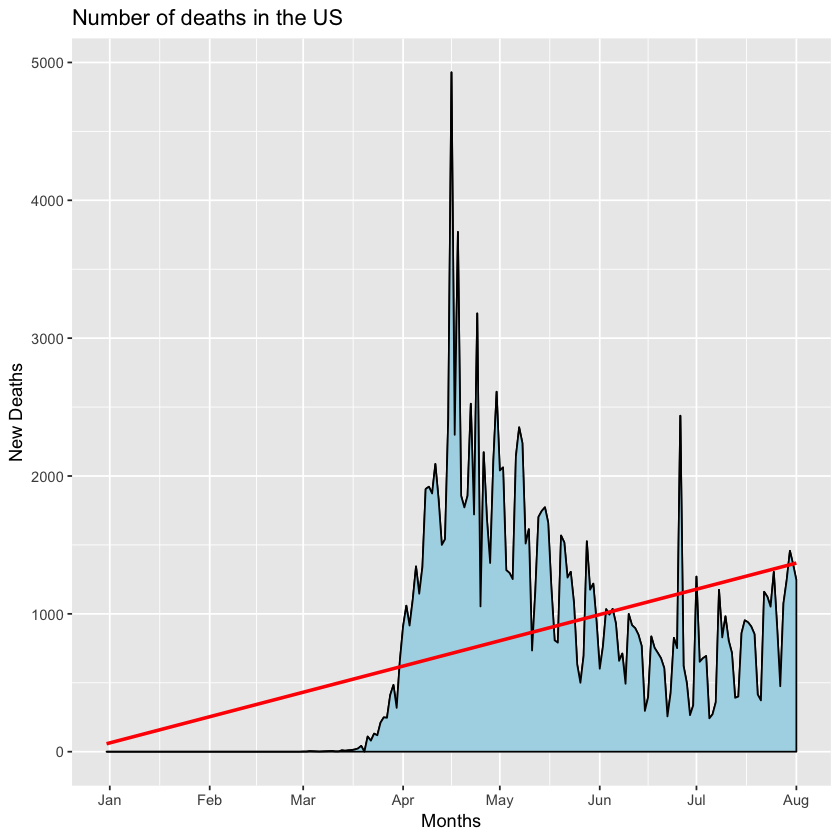

In [4]:
# Load the csv file first.
dat <- read.csv("owid-covid-data.csv")

class(dat$date)
# [1] "factor"

# Here we change the date column into a date type.
dat$date <- as.Date(dat$date)
class(dat$date)
# [1] "Date"


# We pick the US rows only.
dat_US <- dat[dat$location == "United States",c(3,4,7,8)]

p <- ggplot(dat_US, aes(x=date, y=new_deaths)) +
  geom_line() + scale_x_date(date_breaks = "1 month", date_labels = "%b") +
  xlab("Months") + ylab("New Deaths")+ggtitle("Number of deaths in the US")+geom_area(fill="lightblue", color="black")
p

# Let plot the mean to check the first condition if our data is stationary or not.
p + geom_smooth(method = lm, col = "red", se = FALSE)

#geom_smooth(method = "lm",se = FALSE, col = "red")

[1]      0      0      0      0      0      0      0      0      0      0
 [11]      0      0      0      0      0      0      0      0      0      0
 [21]      0      0      0      0      0      0      0      0      0      0
 [31]      0      0      0      0      0      0      0      0      0      0
 [41]      0      0      0      0      0      0      0      0      0      0
 [51]      0      0      0      0      0      0      0      0      0      0
 [61]      0      1      2      6      9     11     12     14     17     21
 [71]     26     28     30     40     47     57     69     85    108    150
 [81]    150    260    340    471    590    801   1050   1296   1707   2191
 [91]   2509   3170   4079   5138   6053   7157   8501   9647  10989  12895
[101]  14817  16690  18777  20608  22108  23649  26057  30985  33284  37054
[111]  38910  40682  42539  45063  46784  49963  51017  53189  54876  56245
[121]  58355  60966  63006  65068  66385  67682  68934  71078  73431  75670
[131]  77180  78794  79528  80684  82387  84133  85906  87568  88754  89562
[141]  90353  91921  93439  94702  96007  97087  97720  98220  98916 100442
[151] 101617 102836 103781 104383 105147 106181 107175 108211 109143 109802
[161] 110514 111007 112006 112924 113820 114669 115436 115732 116127 116963
[171] 117717 118434 119112 119719 119975 120402 121228 121979 124416 125039
[181] 125539 125804 126140 127410 128062 128740 129434 129676 129947 130306
[191] 131480 132309 133291 134097 134814 135205 135605 136466 137419 138358
[201] 139266 140119 140534 140906 142066 143190 144242 145546 146460 146935
[211] 148011 149256 150713 152070 153314

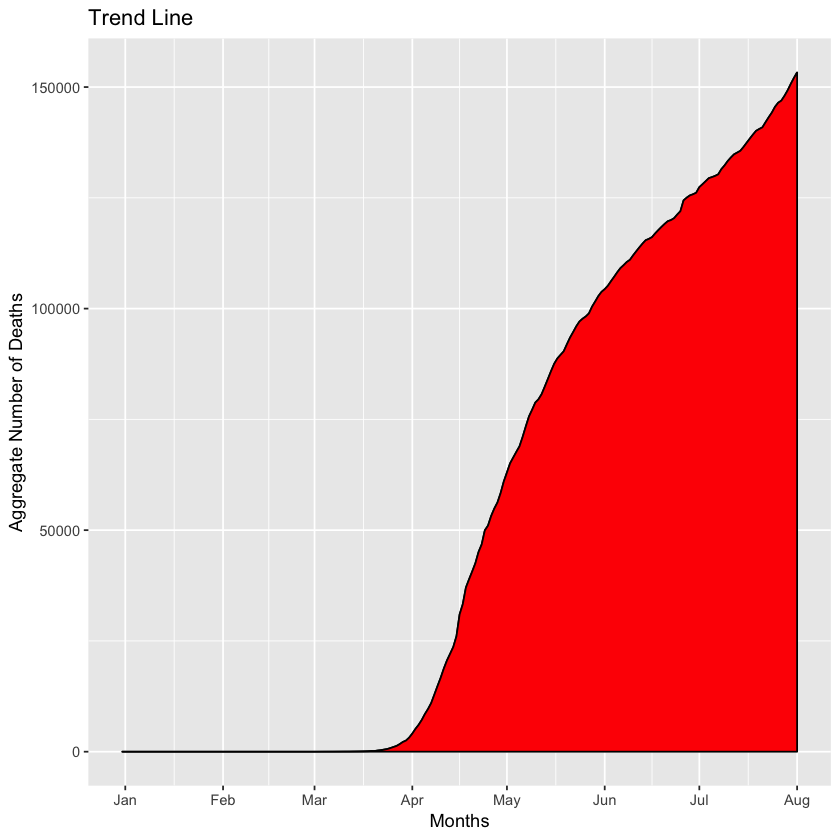

In [5]:
p1 <- ggplot(dat_US, aes(x=date, y=total_deaths)) +
  geom_line() + scale_x_date(date_breaks = "1 month", date_labels = "%b") +
  xlab("Months") + ylab("Aggregate Number of Deaths")+ggtitle("Trend Line")+geom_area(fill="red", color="black")
p1

# Here we can see the aggregate numbers of death.
dat_US$total_deaths

[1] "zoo"

     Index               dat_demo     
 Min.   :2019-12-31   Min.   :   0.0  
 1st Qu.:2020-02-22   1st Qu.:   0.0  
 Median :2020-04-16   Median : 500.0  
 Mean   :2020-04-16   Mean   : 713.1  
 3rd Qu.:2020-06-08   3rd Qu.:1167.0  
 Max.   :2020-08-01   Max.   :4928.0  

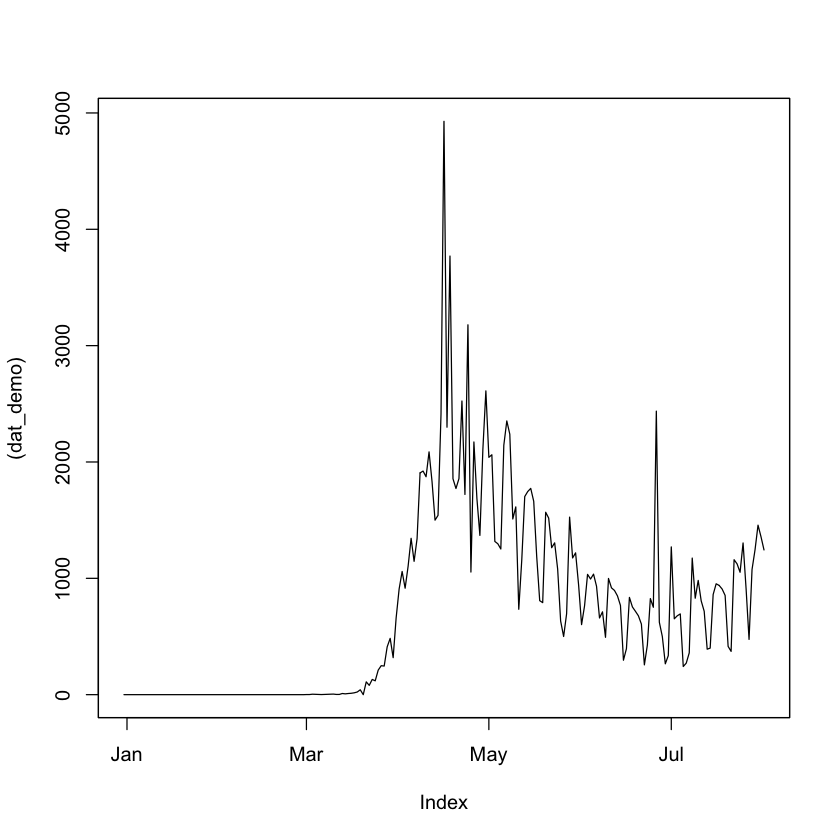

In [6]:
# Change the data to zoo type
dat_US_Analysis <- dat_US[,c(2,4)]
dat_demo <- zoo(dat_US_Analysis$new_deaths, seq(from = as.Date("2019-12-31"), to = as.Date("2020-08-01"), by = 1))

class(dat_demo)

summary(dat_demo)

plot((dat_demo))

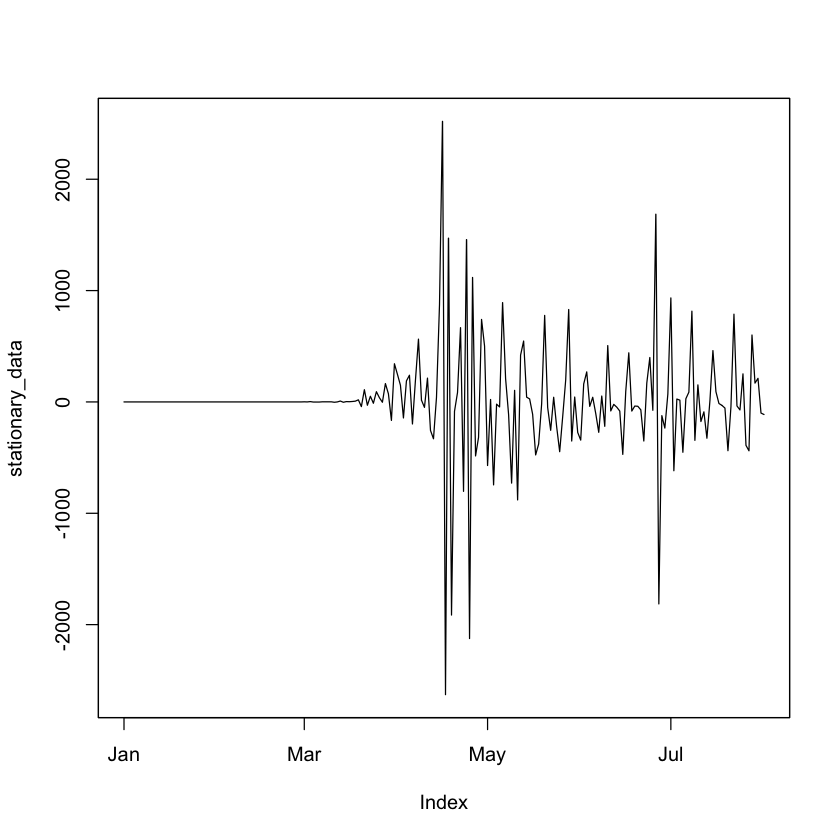

In [7]:
# Make the data stationary, by differencing the data.
stationary_data <- diff(dat_demo)
plot(stationary_data)

In [8]:
# To check if it's stationary we conduct a quantitative test. We use the Augmented Dickey-Fuller Test.
# H_0 = The null hypothesis for this test is that there is a unit root.
# H_A = The alternative hypothesis is that the time series is stationary (or trend-stationary).
adf.test(as.matrix(stationary_data)) 

# We select a significance level of 0.05 and since our p-value is 0.01 and smaller then 0.05, we come to the conclusion to reject the null hypothesis. In other words our data is stationary. 

Warning message in adf.test(as.matrix(stationary_data)):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  as.matrix(stationary_data)
Dickey-Fuller = -10.478, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


## Modeling

We are going to use the ARIMA model to do the Time Series Analysis. 

The ARIMA model forecasts based on it's previous values and it has 3 parameters. The parameters are (p,d,g), which we will need to do our forecasting. 
For further explanation please refer to the paper on page 8 and 9.

We have to find our values p,d and g. Next we demonstrate how to find those values.

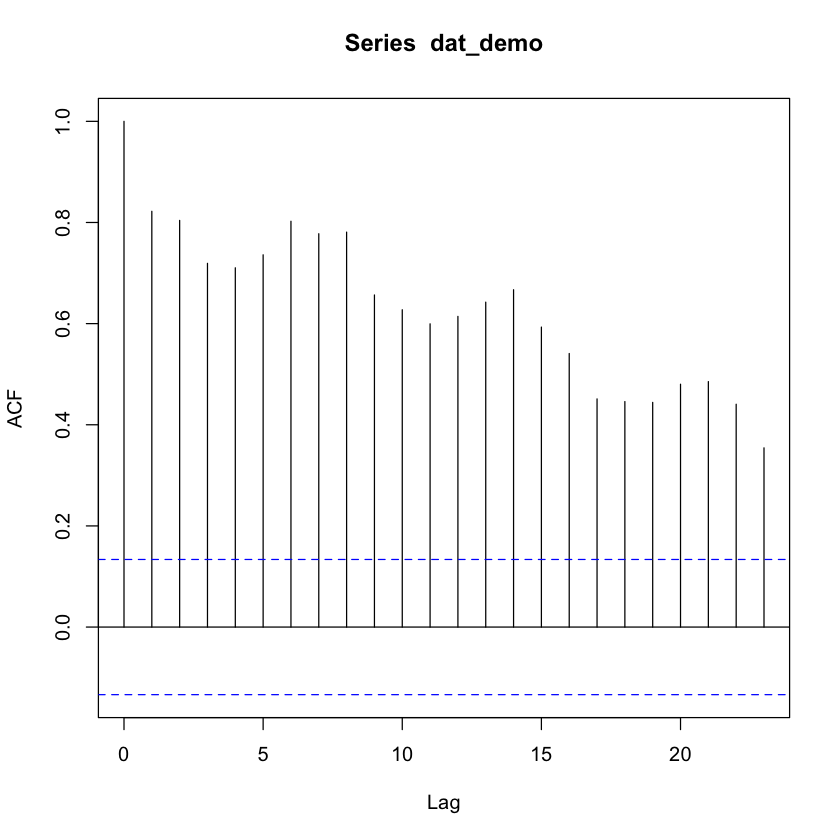

In [9]:
# We use the Auto Correlation Graph

# First we have a look at our acf graph when our data isn't stationary.
acf(dat_demo)
# Here we see that our values are all exceeding the blue line. The goal is to have the values under the blue line and they should be inverted as well.


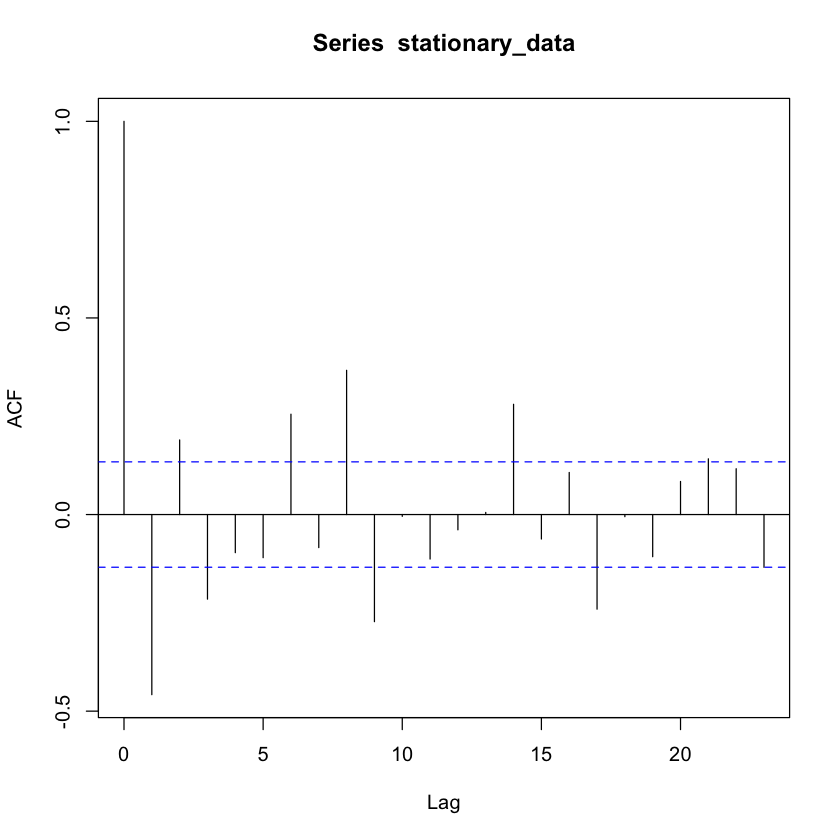

In [10]:
# To select the p and q values we select the number before the first inverted line.
acf(stationary_data)

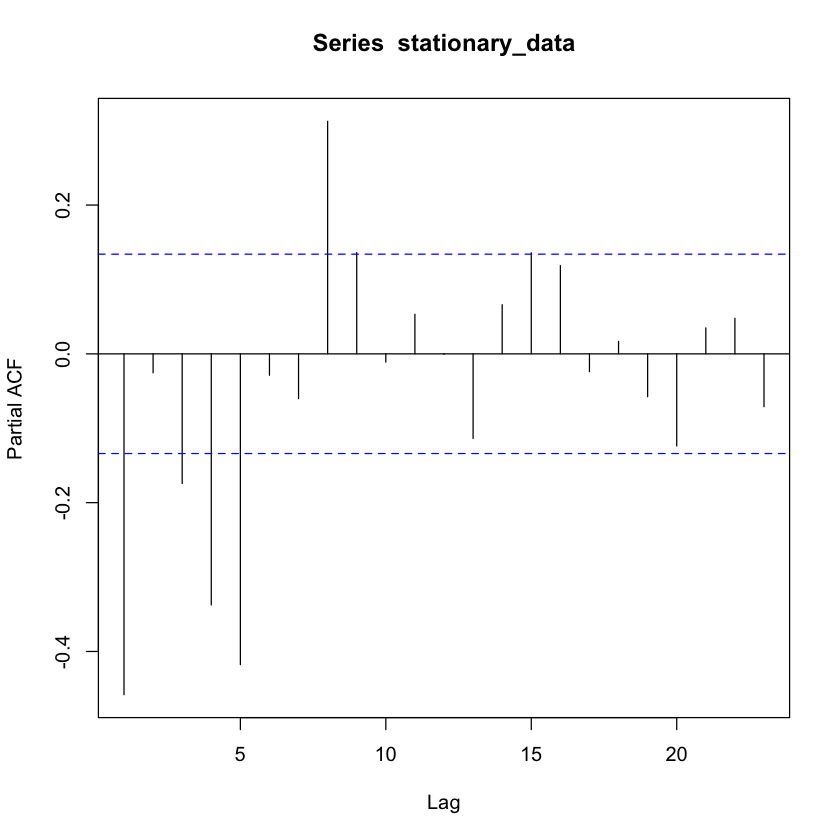

In [11]:
pacf(stationary_data) 

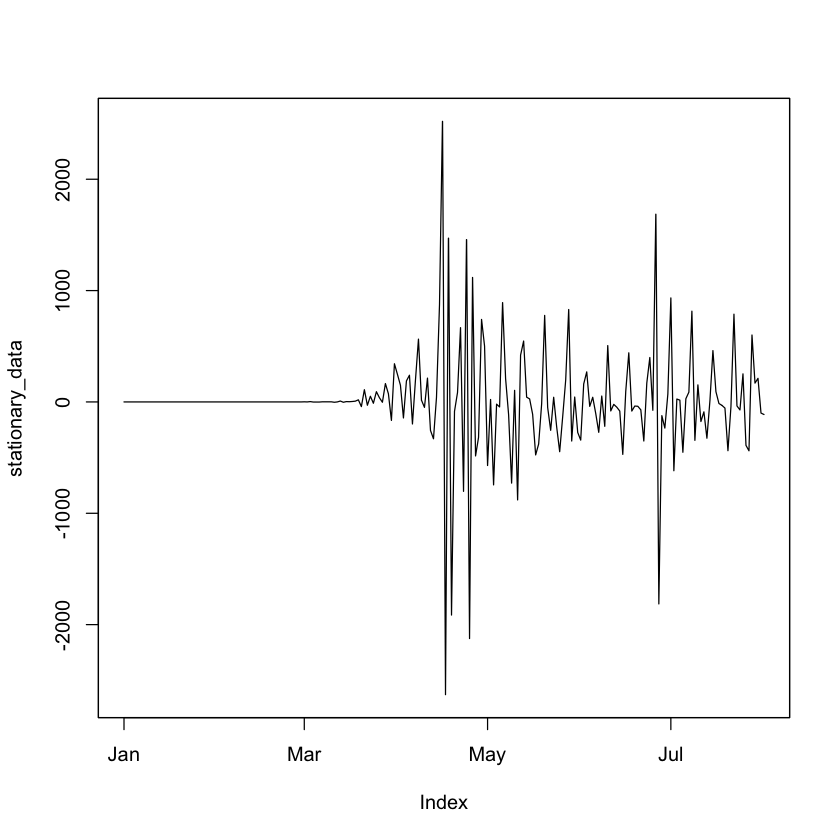

In [12]:
plot(stationary_data)

Series: stationary_data 
ARIMA(3,0,2) with zero mean 

Coefficients:
         ar1      ar2      ar3      ma1     ma2
      0.6082  -0.1778  -0.6058  -1.2614  0.8282
s.e.  0.0599   0.0686   0.0563   0.0460  0.0476

sigma^2 estimated as 126057:  log likelihood=-1558.96
AIC=3129.92   AICc=3130.32   BIC=3150.11

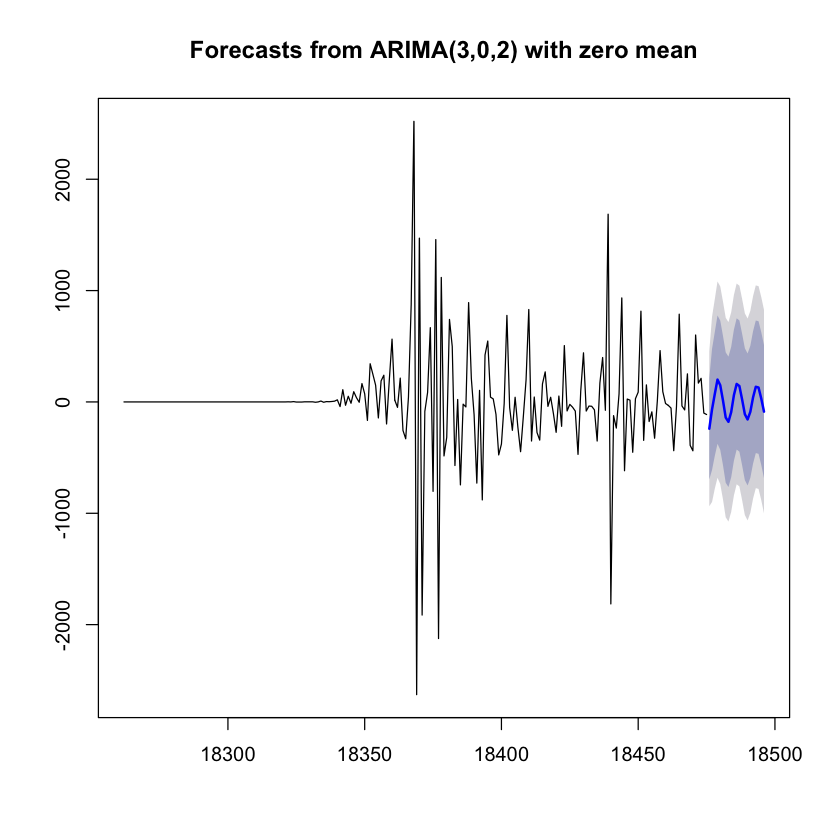

In [13]:
# arima has a auto.arima function which gives us the ideal arima model based on our data.
arima_funct <- auto.arima(stationary_data)
arima_funct

# lets use the auto.arima function to forecast 3 weeks

forecast1 <- forecast(arima_funct, h=21)
additional_deaths <- round(sum(forecast1$upper[,2]),0)
# [1] 18589

total_number_of_deaths <- round(sum(dat_US_Analysis$new_deaths)+additional_deaths,0)
# [1] 171903

# lets use the auto.arima function to forecast 3 months
forecast2 <- forecast(object = arima_funct, h = 90)
additional_deaths2 <- round(sum(forecast2$upper[,2]),0)
# [1] 82653

total_number_of_deaths2 <- round(sum(dat_US_Analysis$new_deaths)+additional_deaths2,0)
# [1] 235967
plot(forecast1)

Below we are just adding the dates and make changes to the x axis for the projected graphs.


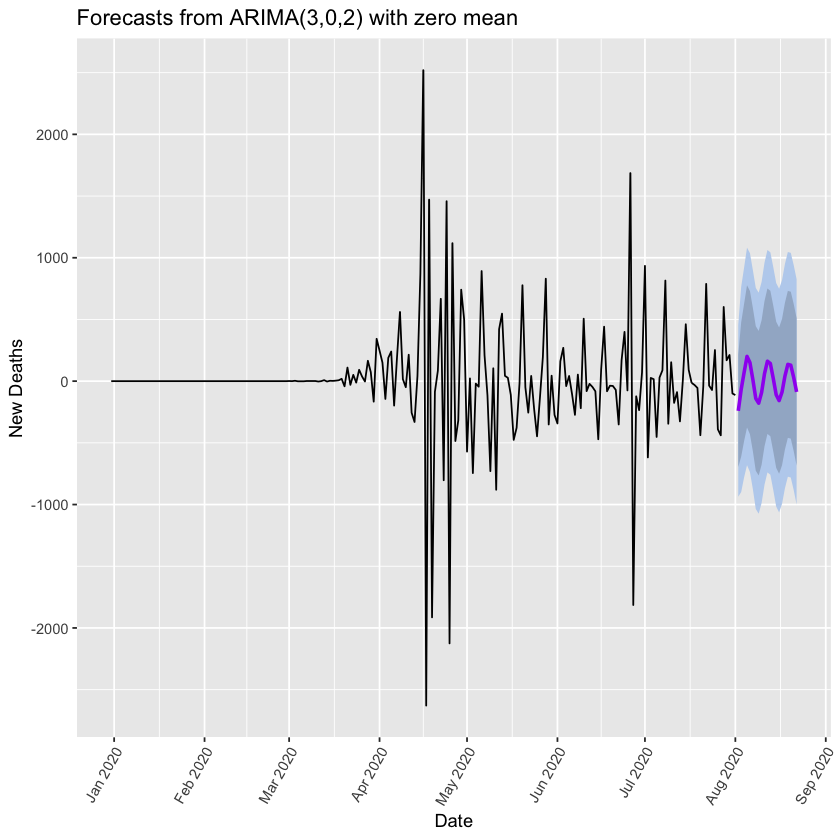

In [14]:
delta <- (forecast1$lower[,2]+forecast1$upper[,2])/2

predicted_21 <- data.frame(date=seq(from=18476,by=1,length=21),new_deaths=delta)
original <- data.frame(date=as.numeric(dat_US_Analysis$date),new_deaths=c(0,stationary_data))
z <- rbind(original,predicted_21)
z$date <- as.Date(z$date)


forecast1_data <- as.data.frame(forecast1)
forecast1_data <- data.frame(date=seq(from=18476,by=1,length=21),forecast1_data, y = delta)
forecast1_data$date <- as.Date(forecast1_data$date)

graph <- ggplot(data=z,aes(x=date,y=new_deaths),show.legend = FALSE)+
  theme(axis.text.x=element_text(angle=60, hjust=1))+
  geom_line(data=original,aes(x=as.Date(date),y=new_deaths))+
  geom_ribbon(data=forecast1_data,aes(x = date,ymin =Lo.95, ymax =Hi.95), inherit.aes = FALSE,fill = "lightsteelblue2")+
  geom_ribbon(data=forecast1_data,aes(x = date,ymin =Lo.80, ymax =Hi.80), inherit.aes = FALSE,fill = "lightsteelblue3")+
  geom_line(data=forecast1_data,aes(x=date,y=y),size=1,color='purple')+
  ggtitle("Forecasts from ARIMA(3,0,2) with zero mean")+
  scale_x_date(date_breaks = "1 month", date_labels =  "%b %Y")+
  labs(x="Date",y="New Deaths")



graph 

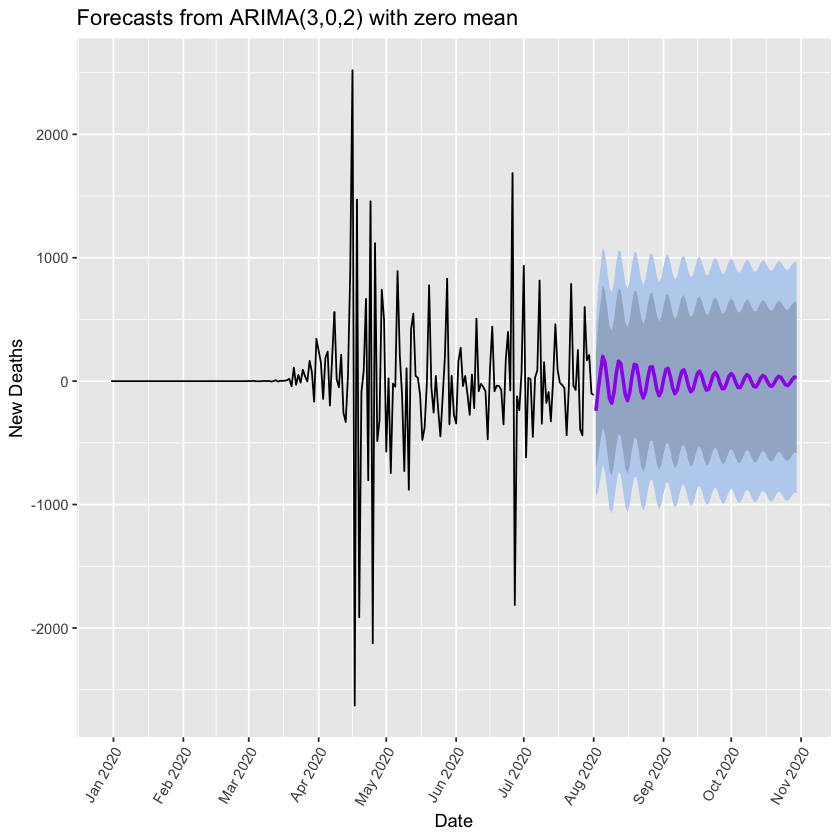

In [15]:
delta2 <- (forecast2$lower[,2]+forecast2$upper[,2])/2

predicted_22 <- data.frame(date=seq(from=18476,by=1,length=nrow(forecast2$lower)),new_deaths=delta2) # prediction from ARIMA
original <- data.frame(date=as.numeric(dat_US_Analysis$date),new_deaths=c(0,stationary_data)) # Previous Observations 
z2 <- rbind(original,predicted_22) # combine the two data sets
z2$date <- as.Date(z2$date) # convert numeric column to date (creating the base layer of ggplot)

forecast2_data <- as.data.frame(forecast2) # convert forecast data into data.frame
forecast2_data <- data.frame(date=seq(from=18476,by=1,length=90),forecast2_data, y = delta2) #add a date and delta of Lo.95 & Hi.95
forecast2_data$date <- as.Date(forecast2_data$date) # covert to date 

graph <- ggplot(data=z2,aes(x=date,y=new_deaths),show.legend = FALSE)+
  theme(axis.text.x=element_text(angle=60, hjust=1))+
  geom_line(data=original,aes(x=as.Date(date),y=new_deaths))+
  geom_ribbon(data=forecast2_data,aes(x = date,ymin =Lo.95, ymax =Hi.95), inherit.aes = FALSE,fill = "lightsteelblue2")+
  geom_ribbon(data=forecast2_data,aes(x = date,ymin =Lo.80, ymax =Hi.80), inherit.aes = FALSE,fill = "lightsteelblue3")+
  geom_line(data=forecast2_data,aes(x=date,y=y),size=1,color='purple')+
  ggtitle("Forecasts from ARIMA(3,0,2) with zero mean")+
  scale_x_date(date_breaks = "1 month", date_labels =  "%b %Y")+
  labs(x="Date",y="New Deaths")



graph 